In [2]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure

#import packages that output memory usage:
#from sys import getsizeof

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import datasets
mask = xr.open_dataset('/data/users/hgilmour/tracking/code/tobac_sensitivity/Save/mask_2005_01.nc')
mask = mask.segmentation_mask
mask #segmentation mask from tracking on Jan 2005 with [240, 200] and [1975, 10]

precip = xr.open_dataset('/data/users/hgilmour/total_precip/precip_1h/precip_2005_01.nc')
precip = precip.stratiform_rainfall_flux #precip dataset for Jan 2005 (NEED TO LATER CONVERT FROM KG M-2 S-1 TO MM/HR (X3600))

tracks = pd.read_hdf('/data/users/hgilmour/tracking/code/tobac_sensitivity/Save/tracks_2005_01.h5', 'table')

tb = xr.open_dataset('/data/users/hgilmour/tb/2005/tb_2005_01.nc')
tb = tb.toa_outgoing_longwave_flux

vert_vel = xr.open_dataset('/data/users/hgilmour/omega/2005/jan_2005_new_combine/omega_merge_01_2005_NEWMERGE1.nc')
vert_vel = vert_vel.dz_dt
#vert_vel = vert_vel.upward_air_velocity
#vert_vel = vert_vel[:,1:,:] # making sure there are 1360 latitudes rather than 1361


In [4]:
vert_vel = vert_vel[:-1,:,1:,:]
vert_vel

<xarray.DataArray 'dz_dt' (t: 240, p: 1, latitude: 1360, longitude: 1360)>
[443904000 values with dtype=float32]
Coordinates:
  * t          (t) datetime64[ns] 2005-01-01 ... 2005-01-30T21:00:00
  * longitude  (longitude) float32 274.9 275.0 275.0 275.1 ... 329.9 329.9 330.0
  * latitude   (latitude) float32 -40.02 -39.98 -39.94 ... 14.94 14.98 15.02
  * p          (p) float32 500.0
Attributes:
    standard_name:  upward_air_velocity
    long_name:      W COMPNT OF WIND ON P LEV/UV GRID
    units:          m s-1
    grid_mapping:   rotated_pole
    source:         Unified Model Output (Vn10.6):
    name:           dz_dt
    title:          W COMPNT OF WIND ON P LEV/UV GRID
    date:           01/01/02
    time:           00:00
    north_pole:     [180.  90.]

In [5]:
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,forecast_reference_time,forecast_period,cell,time_cell
0,0,9,179.648443,518.713643,3617,240,1,2005-01-01 00:30:00,2005-01-01 00:30:00,-32.764288,-64.032043,295.967957,295.967957,1,0 days 00:00:00
1,0,26,319.360864,876.726404,7359,240,2,2005-01-01 00:30:00,2005-01-01 00:30:00,-27.105936,-49.532534,310.467466,310.467466,2,0 days 00:00:00
2,0,57,465.549812,1014.466367,5384,240,3,2005-01-01 00:30:00,2005-01-01 00:30:00,-21.185283,-43.954061,316.045939,316.045939,-1,NaT
3,0,73,763.319602,705.760312,47759,240,4,2005-01-01 00:30:00,2005-01-01 00:30:00,-9.125606,-56.456667,303.543333,303.543333,-1,NaT
4,0,86,577.470368,717.240701,2132,240,5,2005-01-01 00:30:00,2005-01-01 00:30:00,-16.652501,-55.991687,304.008313,304.008313,-1,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9076,743,241,882.032521,698.342702,7910,240,9077,2005-01-31 23:30:00,2005-01-31 23:30:00,-4.317733,-56.757057,303.242943,303.242943,-1,NaT
9077,743,252,940.225439,833.293263,3228,240,9078,2005-01-31 23:30:00,2005-01-31 23:30:00,-1.960920,-51.291560,308.708440,308.708440,-1,NaT
9078,743,272,1046.778633,1275.959222,20583,240,9079,2005-01-31 23:30:00,2005-01-31 23:30:00,2.354484,-33.363590,326.636410,326.636410,-1,NaT
9079,743,320,1097.697734,916.296729,3373,240,9080,2005-01-31 23:30:00,2005-01-31 23:30:00,4.416709,-47.929939,312.070061,312.070061,-1,NaT


In [6]:
vert_vel[1,:,:,:].t

<xarray.DataArray 't' ()>
array('2005-01-01T03:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2005-01-01T03:00:00
Attributes:
    standard_name:  time
    long_name:      t
    axis:           T

In [7]:
mask.shape == precip.shape # checking whether the mask and precip files have the same shape
# next steps won't work if not


True

In [8]:
# Copy tracks dataset into new tracks_precip dataset to append precip data to
tracks = tracks.copy()

In [105]:
# Add columns to the tracks_precip dataframe ready to append data to later
tracks['total_precip'] = 0 #total precip from any precipitating pixel
tracks['rain_flag'] = 0 # total number of pixels that meet the 1mm/hr threshold
tracks['light_precip'] = 0 # total rain from all pixels where the rainfall threshold of 1 mm/hr is met
tracks['heavy_precip'] = 0 # total rain from all pixels where the heavy rainfall threshold of 10 mm/hr is met
tracks['extreme_precip'] = 0 # total rain from all pixels where the extreme rainfall threshold of 50 mm/hr is met
tracks['max_precip'] = 0 # maximum rainfall rate found over the masked area at that timstep
tracks['mean_precip_total'] = 0 # mean rainfall rate found over whole masked area (including non rainy pixels)

tracks['mean_precip'] = 0 # mean rainfall rate found over pixels that meet the precipitation threshold (> 1 mm/hr)


# Add cold core filter columns
tracks['tb_min'] = 0
tracks['tb_mean'] = 0
tracks['cold_core_flag'] = 0
tracks['tb_210'] = 0
tracks['tb_200'] = 0
tracks['tb_190'] = 0

# Add columns for vertical velocity (w)
tracks['w_max'] = float('NaN') # maximum vertical velocity
tracks['w_mean'] = float('NaN') # mean vertical velocity
tracks['w_mean_up'] = float('NaN') # mean vertical velocity of only positive values (i.e. upward motion)

# Add column for datetime
tracks['datetime'] = 0

# Add columns for latitude and longitude of variable maxima / minima
tracks['max_precip_lat'] = 0
tracks['max_precip_lon'] = 0
tracks['min_tb_lat'] = 0
tracks['min_tb_lon'] = 0
tracks['max_w_up_lat'] = 0
tracks['max_w_up_lon'] = 0
tracks['max_w_down_lat'] = 0
tracks['max_w_down_lon'] = 0


# # Add columns for colocated pixels of cold core <= 200K and precip > 1mm/hr



In [106]:
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,forecast_reference_time,forecast_period,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon
0,0,9,179.648443,518.713643,3617,240,1,2005-01-01 00:30:00,2005-01-01 00:30:00,-32.764288,-64.032043,295.967957,295.967957,1,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
1,0,26,319.360864,876.726404,7359,240,2,2005-01-01 00:30:00,2005-01-01 00:30:00,-27.105936,-49.532534,310.467466,310.467466,2,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
7,0,274,994.600931,652.721131,3251,240,8,2005-01-01 00:30:00,2005-01-01 00:30:00,0.241288,-58.604738,301.395262,301.395262,8,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
11,0,326,1136.057059,1330.881404,3448,240,12,2005-01-01 00:30:00,2005-01-01 00:30:00,5.970260,-31.139263,328.860737,328.860737,12,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
12,1,7,179.948634,523.925062,4138,240,13,2005-01-01 01:30:00,2005-01-01 01:30:00,-32.752130,-63.820969,296.179031,296.179031,1,0 days 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9062,742,351,1126.995562,1076.654673,15042,240,9063,2005-01-31 22:30:00,2005-01-31 22:30:00,5.603271,-41.435432,318.564568,318.564568,2222,0 days 08:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
9064,743,28,506.670650,519.857317,40563,240,9065,2005-01-31 23:30:00,2005-01-31 23:30:00,-19.519889,-63.985728,296.014272,296.014272,2193,0 days 15:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
9070,743,97,627.143818,585.244022,13066,240,9071,2005-01-31 23:30:00,2005-01-31 23:30:00,-14.640726,-61.337561,298.662439,298.662439,2218,0 days 10:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
9074,743,208,801.606743,355.515817,3839,240,9075,2005-01-31 23:30:00,2005-01-31 23:30:00,-7.574979,-70.641556,289.358444,289.358444,2233,0 days 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0


In [107]:
# remove cell values with -1 from tracks dataset
tracks = tracks[tracks.cell >= 0]
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,forecast_reference_time,forecast_period,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon
0,0,9,179.648443,518.713643,3617,240,1,2005-01-01 00:30:00,2005-01-01 00:30:00,-32.764288,-64.032043,295.967957,295.967957,1,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
1,0,26,319.360864,876.726404,7359,240,2,2005-01-01 00:30:00,2005-01-01 00:30:00,-27.105936,-49.532534,310.467466,310.467466,2,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
7,0,274,994.600931,652.721131,3251,240,8,2005-01-01 00:30:00,2005-01-01 00:30:00,0.241288,-58.604738,301.395262,301.395262,8,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
11,0,326,1136.057059,1330.881404,3448,240,12,2005-01-01 00:30:00,2005-01-01 00:30:00,5.970260,-31.139263,328.860737,328.860737,12,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
12,1,7,179.948634,523.925062,4138,240,13,2005-01-01 01:30:00,2005-01-01 01:30:00,-32.752130,-63.820969,296.179031,296.179031,1,0 days 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9062,742,351,1126.995562,1076.654673,15042,240,9063,2005-01-31 22:30:00,2005-01-31 22:30:00,5.603271,-41.435432,318.564568,318.564568,2222,0 days 08:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
9064,743,28,506.670650,519.857317,40563,240,9065,2005-01-31 23:30:00,2005-01-31 23:30:00,-19.519889,-63.985728,296.014272,296.014272,2193,0 days 15:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
9070,743,97,627.143818,585.244022,13066,240,9071,2005-01-31 23:30:00,2005-01-31 23:30:00,-14.640726,-61.337561,298.662439,298.662439,2218,0 days 10:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
9074,743,208,801.606743,355.515817,3839,240,9075,2005-01-31 23:30:00,2005-01-31 23:30:00,-7.574979,-70.641556,289.358444,289.358444,2233,0 days 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0


In [108]:
tracks[tracks.cell == 8]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,forecast_reference_time,forecast_period,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon
7,0,274,994.600931,652.721131,3251,240,8,2005-01-01 00:30:00,2005-01-01 00:30:00,0.241288,-58.604738,301.395262,301.395262,8,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
23,1,246,997.302790,649.673525,3985,240,24,2005-01-01 01:30:00,2005-01-01 01:30:00,0.350713,-58.728157,301.271843,301.271843,8,0 days 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
40,2,207,1000.085394,647.171876,4462,240,41,2005-01-01 02:30:00,2005-01-01 02:30:00,0.463408,-58.829496,301.170504,301.170504,8,0 days 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
53,3,151,1003.611792,643.427105,4439,240,54,2005-01-01 03:30:00,2005-01-01 03:30:00,0.606227,-58.981147,301.018853,301.018853,8,0 days 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
68,4,153,1001.760375,637.916268,3516,240,69,2005-01-01 04:30:00,2005-01-01 04:30:00,0.531246,-59.204349,300.795651,300.795651,8,0 days 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
82,5,161,1002.426140,633.101328,1978,240,83,2005-01-01 05:30:00,2005-01-01 05:30:00,0.558210,-59.399339,300.600661,300.600661,8,0 days 05:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
97,6,178,999.329845,589.566796,2196,240,98,2005-01-01 06:30:00,2005-01-01 06:30:00,0.432808,-61.162502,298.837498,298.837498,8,0 days 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
110,7,166,1005.332832,573.307600,2083,240,111,2005-01-01 07:30:00,2005-01-01 07:30:00,0.675929,-61.820978,298.179022,298.179022,8,0 days 07:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0


In [109]:
cells = np.unique(tracks.cell.values)
cells

array([   1,    2,    8,   12,   14,   27,   28,   45,   48,   50,   54,
         56,   57,   59,   60,   62,   64,   66,   70,   73,   89,   91,
         98,  104,  106,  116,  118,  122,  124,  127,  128,  130,  134,
        135,  137,  138,  151,  154,  162,  165,  178,  185,  195,  204,
        207,  212,  215,  222,  223,  224,  226,  234,  247,  271,  276,
        287,  293,  296,  306,  307,  309,  324,  326,  339,  345,  354,
        358,  364,  369,  371,  376,  396,  399,  406,  407,  408,  409,
        413,  414,  418,  429,  434,  437,  441,  442,  443,  445,  449,
        451,  453,  458,  459,  467,  492,  498,  500,  514,  516,  518,
        522,  524,  529,  539,  541,  544,  545,  548,  549,  551,  552,
        554,  558,  566,  567,  577,  584,  587,  588,  590,  596,  601,
        603,  605,  608,  611,  615,  619,  621,  622,  624,  630,  631,
        634,  636,  638,  646,  647,  652,  666,  670,  673,  677,  681,
        682,  689,  695,  698,  716,  721,  725,  7

Feature: 55
Frame: 3
Frame timestamp:  54    2005-01-01 03:30:00
Name: timestr, dtype: object
original frame timestamp:  54    2005-01-01 03:30:00
Name: timestr, dtype: object
w frame number:  1
w frame timestamp:  <xarray.DataArray 't' ()>
array('2005-01-01T03:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2005-01-01T03:00:00
Attributes:
    standard_name:  time
    long_name:      t
    axis:           T
maximum w within mask: 8.603626


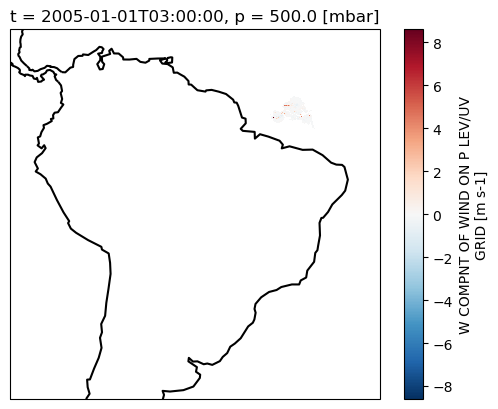

Skipping this frame and assinging NaN
Feature: 71
Frame: 4
Frame timestamp:  70    2005-01-01 04:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 85
Frame: 5
Frame timestamp:  84    2005-01-01 05:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 100
Frame: 6
Frame timestamp:  99    2005-01-01 06:30:00
Name: timestr, dtype: object
original frame timestamp:  99    2005-01-01 06:30:00
Name: timestr, dtype: object
w frame number:  2
w frame timestamp:  <xarray.DataArray 't' ()>
array('2005-01-01T06:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2005-01-01T06:00:00
Attributes:
    standard_name:  time
    long_name:      t
    axis:           T
maximum w within mask: 8.699401


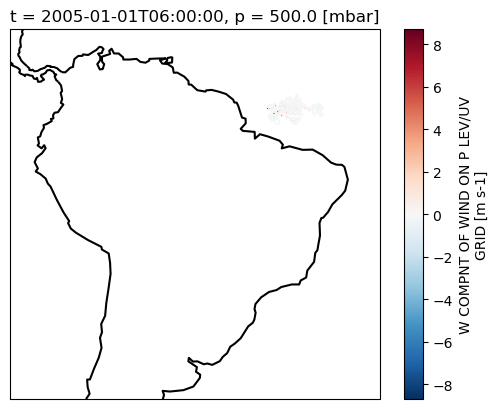

Skipping this frame and assinging NaN
Feature: 113
Frame: 7
Frame timestamp:  112    2005-01-01 07:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 121
Frame: 8
Frame timestamp:  120    2005-01-01 08:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 130
Frame: 9
Frame timestamp:  129    2005-01-01 09:30:00
Name: timestr, dtype: object
Feature: 139
Frame: 10
Frame timestamp:  138    2005-01-01 10:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 149
Frame: 11
Frame timestamp:  148    2005-01-01 11:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 157
Frame: 12
Frame timestamp:  156    2005-01-01 12:30:00
Name: timestr, dtype: object
original frame timestamp:  156    2005-01-01 12:30:00
Name: timestr, dtype: object
w frame number:  4
w frame timestamp:  <xarray.DataArray 't' ()>
array('2005-01-01T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t  

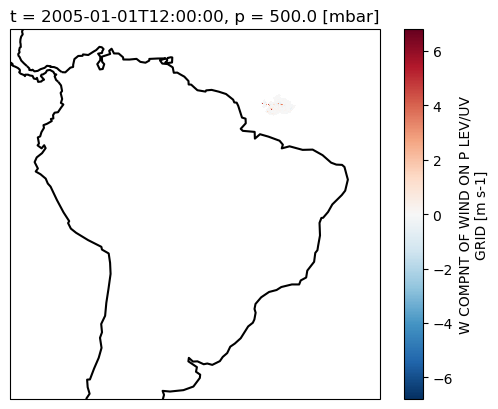

Skipping this frame and assinging NaN
Feature: 165
Frame: 13
Frame timestamp:  164    2005-01-01 13:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 177
Frame: 14
Frame timestamp:  176    2005-01-01 14:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 189
Frame: 15
Frame timestamp:  188    2005-01-01 15:30:00
Name: timestr, dtype: object
original frame timestamp:  188    2005-01-01 15:30:00
Name: timestr, dtype: object
w frame number:  5
w frame timestamp:  <xarray.DataArray 't' ()>
array('2005-01-01T15:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2005-01-01T15:00:00
Attributes:
    standard_name:  time
    long_name:      t
    axis:           T
maximum w within mask: 8.246369


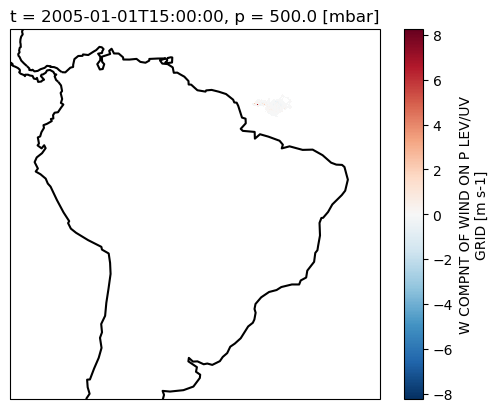

Skipping this frame and assinging NaN
Feature: 199
Frame: 16
Frame timestamp:  198    2005-01-01 16:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 215
Frame: 17
Frame timestamp:  214    2005-01-01 17:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 234
Frame: 18
Frame timestamp:  233    2005-01-01 18:30:00
Name: timestr, dtype: object
original frame timestamp:  233    2005-01-01 18:30:00
Name: timestr, dtype: object
w frame number:  6
w frame timestamp:  <xarray.DataArray 't' ()>
array('2005-01-01T18:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2005-01-01T18:00:00
Attributes:
    standard_name:  time
    long_name:      t
    axis:           T
maximum w within mask: 3.513307


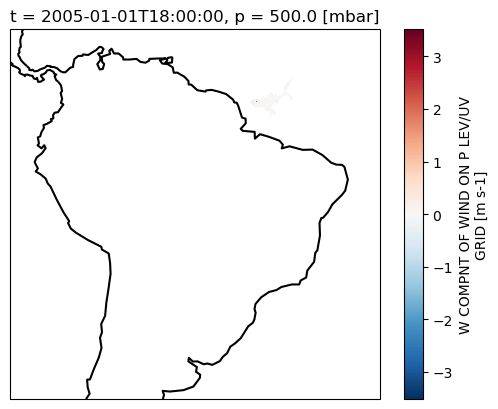

Skipping this frame and assinging NaN
Feature: 256
Frame: 19
Frame timestamp:  255    2005-01-01 19:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Feature: 280
Frame: 20
Frame timestamp:  279    2005-01-01 20:30:00
Name: timestr, dtype: object
Skipping this frame and assinging NaN
Completed cell  27


In [112]:
## TESTING LOOP FOR A SINGLE UNIQUE CELL (E.G. NUMBER 12) ##

## rainfall thresholds to use within filtering loop ##
precip_threshold = 1 #mm/hr
heavy_precip_threshold = 10 # mm/hr
extreme_precip_threshold = 50 # mm/hr (based on Marengo, J. A., Ambrizzi, T., Alves, L. M., Barreto, N. J., Simões Reboita, M., & Ramos, A. M. (2020). Changing trends in rainfall extremes in the metropolitan area of São Paulo: causes and impacts. Frontiers in Climate, 2, 3.)
precip_area = 25 # threshold for the minimum number of grid points that must be precipitating for a track to remain (and not be dropped from the tracks dataset)

cold_threshold = 200

## other parameters that need to be defined before loop ##
s = generate_binary_structure(2,2) # need this in loop later on
removed = 0 # need this for loop later on


cell = 27
subset = tracks[tracks.cell == cell]
precipitation_flag = 0
cold_core_flag = 0
w_frame = 0 # assigning the frame number of the vertical velocity dataset to be 0 (i.e. vert_vel[w_frame,:,:,:] = vert_vel[0,:,:,:])

for feature in subset.feature.values: #find all the feature values for that unique cell / track (the feature value is a unique value for each feature in a frame /timestep)
    print("Feature:", feature)
    for frame in subset.frame[subset.feature == feature]: #find the frame / timestep that corresponds to the feature number
        print("Frame:", frame)
        print("Frame timestamp: ", str(subset['timestr'][subset.frame == frame]))

        subset['datetime'][(subset.frame == frame) & (subset.cell == cell)] = pd.to_datetime(subset['timestr'][subset.frame == frame]) # the time at the hourly frame

        if mask.shape == precip.shape:
        
            seg = mask[frame,:,:] #printing the segmentation mask which occurs in the same frame as the feature value
            #print(seg)
            prec = precip[frame,:,:] #printing the precip timesteps which occurs in the same frame as the feature value
            #print(prec)
            brightness_temp = tb[frame,:,:] # printing the tb timesteps which occurs in the same frame as the feature value
            brightness_temp = tb[frame,:,:] # printing the tb timesteps which occurs in the same frame as the feature value


            featureid = subset.feature[subset.frame == frame].values[0] #find the feature number at each timestep / frame of the cells lifetime (it changes over time and doesn't stay constant)
            #print('featureid: {}'.format(featureid)) #we now know all the feature numbers that belong to a single cell over its lifetime
            
            
            labels, num_labels = ndimage.label(seg, structure = s) #this line uses ndimage package for image processing. It generates arrays of numbers and decides what are joined together and what aren't.
            # In other words, it does image segmentation tasks, such as finding connected components and labeling objects in an image.
            # (i.e. it generates the locations of all contiguous fields of the segmentation mask that belong to a specific cell at a specific timestep and gives it a label. The number of labels is also recorded (the number of segmented areas in the timestep))

            if featureid not in seg: #check that the feature id number at each timestep is within the segmentation mask, if not, it is ignored and we continue
                continue
            else:

                label = np.unique(labels[seg == featureid])[0] #put a label where the labels match for both the feature id and the segmentation mask
                seg_mask = seg.where(labels == label)

                #create coordinates from mask
                seg_mask.coords['mask'] = (('longitude', 'latitude'), seg_mask.data)

                #apply mask to precip dataset
                precip_values = prec.where(seg_mask.coords['mask'].values > 0) # creating a new dataset called 'precip_values' with only the precip values where the seg_mask pixel is labelled as greater than 0 (i.e. the MCS region)
                #print('precip values: {}'.format(precip_values)
                array = precip_values.values.flatten() * 3600 # precip values are converted to 1D numpy array and multiplied by 3600 to convert from kg m-2 s-1 to mm / hr
                values = array[~np.isnan(array)] #removes NaNs from the precip array for further calculations
                #print(values)

                total_precip = np.nansum(values[values > 0]) #working out the total precip associated with the mask. First, values of 0 are removed to only consider precipitating pixels. Then np.nansum is used to compute the sum of all precipitating values within the mask.
                #print('total precip: {}'.format(total_precip))
                subset['total_precip'][(subset.feature == featureid) & (subset.frame == frame)  & (subset.cell == cell)] = total_precip

                rain_features = values[values >= precip_threshold].shape[0] #number of pixels within the mask that meet the 1 mm/hr precip threshold
                #print('rain features: {}'.format(rain_features))
                subset['rain_flag'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = rain_features

                subset['light_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = np.nansum(values[values >= precip_threshold]) #total rain from all pixel where the rainfall threshold of 1 mm/hr is met

                subset['heavy_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = np.nansum(values[values >= heavy_precip_threshold]) #total rain from all pixel where the heavy rainfall threshold of 10 mm/hr is met
                rain_features_heavy = values[values >= heavy_precip_threshold].shape[0] #number of pixels within the mask that meet the heavy rainfall threshold of 10 mm/hr

                subset['extreme_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = np.nansum(values[values >= extreme_precip_threshold]) #total rain from all pixel where the extreme rainfall threshold of 50 mm/hr is met
                rain_features_extreme = values[values >= extreme_precip_threshold].shape[0] #number of pixels within the mask that meet the extreme rainfall threshold of 50 mm/hr

                subset['max_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values.max()

                subset['mean_precip_total'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values.mean()

                subset['mean_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values[values > precip_threshold].mean()

                subset['max_precip_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = precip_values.where(precip_values==precip_values.max(), drop=True).squeeze().latitude

                subset['max_precip_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = precip_values.where(precip_values==precip_values.max(), drop=True).squeeze().longitude

                # cold core filter using the same image processing mask ##
                values_tb_1 = brightness_temp.where(seg_mask.coords['mask'].values > 0)
                array_tb = values_tb_1.values.flatten() # precip values are converted to 1D numpy array and multiplied by 3600 to convert from kg m-2 s-1 to mm / hr
                values_tb = array_tb[~np.isnan(array_tb)] #removes NaNs from the precip array for further calculations
                #print(values_tb[values_tb <= 190].shape[0])
                #array = values_tb.to_dataframe
                #values_tb = array().toa_outgoing_longwave_flux #Tb values in 1D array format to use in section below:

                subset['tb_mean'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb.mean()

                subset['tb_min'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb.min()

                subset['tb_210'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = (values_tb[values_tb <= 210]).shape[0]
                
                subset['tb_200'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = (values_tb[values_tb <= 200]).shape[0]             

                subset['tb_190'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = (values_tb[values_tb <= 190]).shape[0]

                subset['min_tb_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb_1.where(values_tb_1==values_tb_1.min(), drop=True).squeeze().latitude

                subset['min_tb_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb_1.where(values_tb_1==values_tb_1.min(), drop=True).squeeze().longitude  
       

                # Assigning cold core flag
                if values_tb.min() <= cold_threshold:
                    cold_core_flag += 1
                    subset['cold_core_flag'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = cold_core_flag

                if rain_features >= precip_area: # if the number of precipitating pixels exceeds the miniumum pixel number... 
                    precipitation_flag += rain_features # add rain pixels to the precipitation flag

                


            # ADDING IN IF STATEMENT FOR VERTICAL VELOCITY EVERY 3 TIMESTEPS#

            vert_vel_df = pd.DataFrame()

            vert_vel_df['datetime'] = vert_vel[:,:,:,:].t

            for time in vert_vel_df['datetime'].dt.strftime('%Y-%m-%d %H:30:00'): # adding in the 30 so that its the hour of the vert_vel dataset + 30 mins to match up with the 1 hourly data

                if subset['datetime'][subset.frame == frame].to_string(index=False)==time:
                    #print(time)

                    for i in vert_vel_df.index:
                        if (vert_vel[i,:,:,:].t.dt.strftime('%Y-%m-%d %H:30:00')) == time: #if the timestamp in the vert_vel dataset matches with the original frame timestamp...
                            w_frame = i

                            vel_w = vert_vel[w_frame,:,:,:] #find the vertical velocity values for the frame in the vert_vel dataset that corresponds to the frame in the hourly datasets (i.e if the original frame is at 03:00, then find the w values in the vert_vel dataset that are also at 03:00. THEY WILL BE DIFFERENT FRAME NUMBERS BECAUSE THE ORIGINAL IS 1-HOURLY AND W IS 3-HOURLY!!!)

                            print("original frame timestamp: ", str(subset['timestr'][subset.frame == frame]))
                            print("w frame number: ", w_frame)
                            print("w frame timestamp: ", str(vert_vel[w_frame,:,:,:].t))

                            #seg_mask.coords['mask'] = (('longitude', 'latitude'), seg_mask.data) 
                            values_vel = vel_w.where(seg_mask.coords['mask'].values > 0) # extract only the w values within the segmented cell
                            array_vel = values_vel.values.flatten()
                            values_vel = array_vel[~np.isnan(array_vel)] # convert these into a 1D array with no nans
                            print("maximum w within mask:", values_vel.max())

                            ax = plt.axes(projection=ccrs.PlateCarree())
                            vel_w.where(seg_mask.coords['mask'].values > 0).plot(ax=ax, transform=ccrs.PlateCarree())
                            ax.coastlines(linewidth=1.5)
                            plt.show()

                            subset['w_max'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel.max() #maximum vertical velocity over the segmented area
                            subset['w_mean'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel.mean() # mean vertical velocity over the segmented area

                            w_up = values_vel[values_vel >= 0.000000001] # isolating just positive values of w (just upward motion and not downward)

                            subset['w_mean_up'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = w_up.mean() # mean upward vertical velocity over the segmented area

                            subset['max_w_up_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = vel_w.where(vel_w==vel_w.max(), drop=True).squeeze().latitude

                            subset['max_w_up_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = vel_w.where(vel_w==vel_w.max(), drop=True).squeeze().longitude

                            subset['max_w_down_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = vel_w.where(vel_w==vel_w.min(), drop=True).squeeze().latitude

                            subset['max_w_down_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = vel_w.where(vel_w==vel_w.min(), drop=True).squeeze().longitude

                #ADD ANOTHER TIMESTEP ONTO W_FRAME FOR 3HRLY VERTICAL VELOCITY 
                w_frame = w_frame + 1  #add 1 to the vertical_velocity frame ready for the next time the hours are the same

            else:
                print("Skipping this frame and assinging NaN") # if the hour doesn't correspond with one of the 3-hourly values, then assign NaNs to the dataframe


if cold_core_flag == 0:
    subset = subset.drop(subset[subset.cell == cell].index)
    removed += 1 #print the number of tracks that have been removed from the original dataset

    #save subset to deleted tracks folder
    #subset.to_hdf('Save/deleted_tracks/cold_core/tracks_2005_01_cell_{}'.format(cell), 'table')
    
if precipitation_flag == 0: #if the minumum precipitating pixel thresholds aren't met...
    #remove corresponding cell from the tracks dataframe
    subset = subset.drop(subset[subset.cell == cell].index)
    removed += 1 #print the number of tracks that have been removed from the original dataset

    #save subset to deleted tracks folder
    #subset.to_hdf('Save/deleted_tracks/precip/tracks_2005_01_cell_{}'.format(cell), 'table')

else:
    print("Completed cell ", cell)    
    # save precip track files
    #subset.to_hdf('Save/CC&PF/tracks_2005_01_cell_{}.h5'.format(cell), 'table')

In [113]:
pd.set_option('display.max_columns', 100)

subset

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,forecast_reference_time,forecast_period,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon
54,3,156,1059.283254,1036.028507,8336,240,55,2005-01-01 03:30:00,2005-01-01 03:30:00,2.860921,-43.080785,316.919215,316.919215,27,0 days 00:00:00,20488.033203,1437,20186.322266,16856.437500,6724.441895,145.531815,2.463984,14.047545,192.219803,217.108215,1,2826,545,0,8.603626,0.070506,0.349731,2005-01-01 03:30:00,1.836948,317.242065,1.877449,314.164062,0.763701,291.301788,293.691284,0
70,4,165,1062.705879,1024.905056,8281,240,71,2005-01-01 04:30:00,2005-01-01 04:30:00,2.999537,-43.531280,316.468720,316.468720,27,0 days 01:00:00,17284.062500,1662,16970.460938,12482.190430,3748.356445,116.627235,2.090730,10.210867,195.121536,215.948868,2,3079,321,0,NaN,NaN,NaN,2005-01-01 04:30:00,2.484951,314.771545,1.877449,314.366547,0,0,0,0
84,5,174,1062.801139,1039.558649,11750,240,85,2005-01-01 05:30:00,2005-01-01 05:30:00,3.003395,-42.937826,317.062174,317.062174,27,0 days 02:00:00,20325.832031,1933,19863.535156,15024.326172,3042.365234,128.968079,1.731479,10.276014,194.602234,218.058563,3,2910,123,0,NaN,NaN,NaN,2005-01-01 05:30:00,2.525448,314.32605,3.254448,313.637543,0,0,0,0
99,6,192,1063.289231,1029.188475,12169,240,100,2005-01-01 06:30:00,2005-01-01 06:30:00,3.023162,-43.357815,316.642185,316.642185,27,0 days 03:00:00,19326.771484,1998,18844.976562,13317.444336,2888.435791,99.295662,1.613792,9.431920,195.690582,220.037277,4,2521,153,0,8.699401,0.051383,0.224858,2005-01-01 06:30:00,2.68745,317.485046,2.525448,314.407043,-5.5138,289.479279,323.175293,0
112,7,171,1062.533388,1022.727270,11104,240,113,2005-01-01 07:30:00,2005-01-01 07:30:00,2.992552,-43.619504,316.380496,316.380496,27,0 days 04:00:00,22835.574219,1981,22271.087891,17530.355469,7397.307617,156.298889,2.081069,11.242346,191.738998,220.743103,5,2171,160,0,NaN,NaN,NaN,2005-01-01 07:30:00,1.91795,313.394562,3.821449,315.62204,0,0,0,0
120,8,161,1062.368982,1012.581766,9470,240,121,2005-01-01 08:30:00,2005-01-01 08:30:00,2.985894,-44.030395,315.969605,315.969605,27,0 days 05:00:00,19519.828125,1466,19118.146484,15474.836914,6641.437988,128.983749,2.041609,13.041028,192.613998,220.295181,6,2142,312,0,NaN,NaN,NaN,2005-01-01 08:30:00,3.86195,315.379059,3.780949,315.460052,0,0,0,0
129,9,177,1065.205536,1010.273856,7852,240,130,2005-01-01 09:30:00,2005-01-01 09:30:00,3.100774,-44.123858,315.876142,315.876142,27,0 days 06:00:00,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,NaN,NaN,NaN,2005-01-01 09:30:00,0,0,0,0,0,0,0,0
138,10,179,1069.088413,1001.576633,8107,240,139,2005-01-01 10:30:00,2005-01-01 10:30:00,3.258029,-44.476099,315.523901,315.523901,27,0 days 07:00:00,17418.269531,1345,17046.855469,12999.074219,6050.057129,176.148407,2.150404,12.674242,192.931793,219.747269,7,1795,212,0,NaN,NaN,NaN,2005-01-01 10:30:00,3.051949,314.083069,3.051949,314.123566,0,0,0,0
148,11,195,1072.952903,998.185527,7029,240,149,2005-01-01 11:30:00,2005-01-01 11:30:00,3.414543,-44.613428,315.386572,315.386572,27,0 days 08:00:00,14781.599609,1239,14470.511719,10963.625977,4394.683105,127.359093,2.101151,11.679186,194.037476,219.356537,8,1756,315,0,NaN,NaN,NaN,2005-01-01 11:30:00,3.051949,313.961548,3.051949,313.921051,0,0,0,0
156,12,218,1075.924133,987.737107,5781,240,157,2005-01-01 12:30:00,2005-01-01 12:30:00,3.534876,-45.036586,314.963414,314.963414,27,0 days 09:00:00,10522.900391,1130,10306.607422,6951.593262,1776.605347,99.160797,1.819627,9.120892,196.639252,219.105164,9,1555,43,0,6.792889,0.069991,0.225906,2005-01-01 12:30:00,3.942951,314.609558,3.011448,314.366547,7.041201,301.588806,295.716278,0


In [96]:
vel_w = vert_vel[3,:,:,:]
vel_w_max = vel_w.max()
print(vel_w_max)

<xarray.DataArray 'dz_dt' ()>
array(10.864166, dtype=float32)
Coordinates:
    t        datetime64[ns] 2005-01-01T09:00:00


In [97]:
#vel_w.where(vel_w >= 3).plot(cmap='Reds',xlim=[280,300],ylim=[-5,0])

In [98]:
values_vel = vel_w.where(seg_mask.coords['mask'].values > 0) # extract only the w values within the segmented cell
array_vel = values_vel.values.flatten()
values_vel = array_vel[~np.isnan(array_vel)] # convert these into a 1D array with no nans
print(values_vel.max())

4.636358


<xarray.DataArray 'segmentation_mask' (latitude: 1360, longitude: 1360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time                     datetime64[ns] 2005-01-07T03:30:00
  * latitude                 (latitude) float32 -40.04 -40.0 ... 14.96 15.0
  * longitude                (longitude) float32 275.0 275.0 ... 330.0 330.0
    forecast_period          timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
Attributes:
    long_name:     segmentation_mask
    units:         1
    grid_mapping:  latitude_longitude


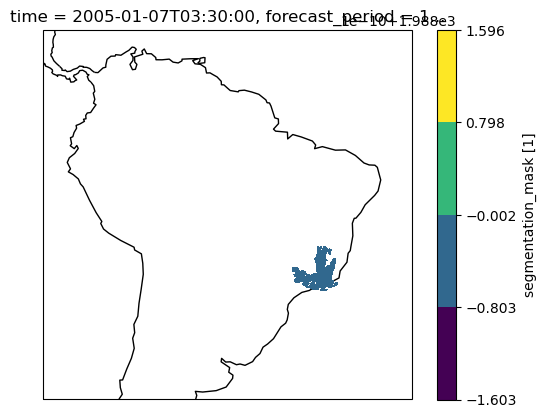

In [99]:
seg_mask = seg.where(labels == label)

print(seg_mask)

ax = plt.axes(projection=ccrs.PlateCarree())
seg_mask.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),zorder=5)
ax.coastlines()


<xarray.DataArray 'dz_dt' ()>
array(0.14481795, dtype=float32)
Coordinates:
    t        datetime64[ns] 2005-01-01T09:00:00

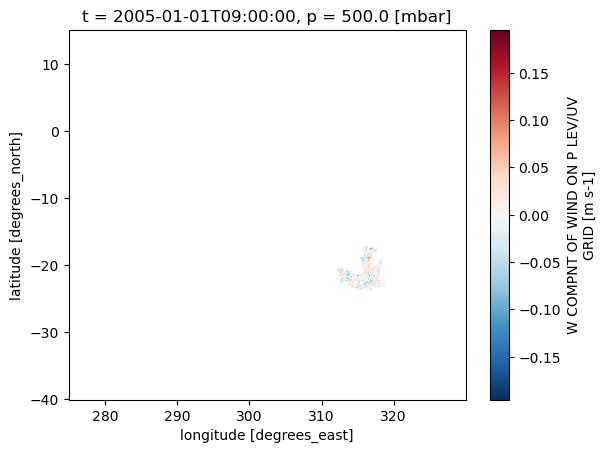

In [100]:
seg_mask.coords

seg_mask.coords['mask'] = (('longitude', 'latitude'), seg_mask.data)

vel_w.where(seg_mask.coords['mask'].values > 0).plot(zorder=1)

vel_w.where(seg_mask.coords['mask'].values > 0).max()


In [104]:
## Location of the precipitation maxima within the cloud shield at each timestep ##

da = prec.where(seg_mask.coords['mask'].values > 0)

da.where(da==da.max(), drop=True).squeeze().latitude

<xarray.DataArray 'latitude' ()>
array(-21.57205, dtype=float32)
Coordinates:
    time                     datetime64[ns] 2005-01-07T03:30:00
    latitude                 float32 -21.57
    longitude                float32 315.7
    forecast_period          timedelta64[ns] 1102 days 03:30:00
    forecast_reference_time  datetime64[ns] 2002-01-01
Attributes:
    axis:           Y
    units:          degrees_north
    standard_name:  latitude

40

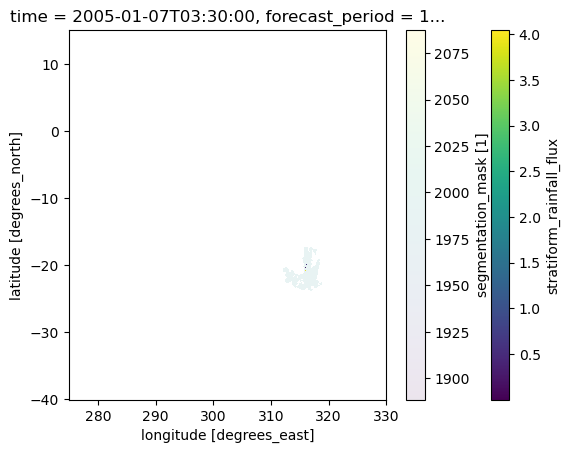

In [102]:
## code for the number of colocated pixels within each timestep of a cloud shield ##

prec = prec * 3600 # converting from kg m-2 s-1 to mm/hr

colocated = prec.where((brightness_temp <= 210) & (seg_mask.coords['mask'].values > 0)) #finding only the locations where all tb and precip criteria are met
colocated.plot()
seg_mask.plot(alpha=0.1)

colocated_pixels = colocated.values[~np.isnan(colocated)].shape[0]
colocated_pixels